In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
from scipy.constants import pi, c as speed_of_light
import configparser
from tqdm.notebook import tqdm

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts


from utils.custom_configparser import CustomConfigParser
from core import channels
from utils.misc import ray_to_elevation_azimuth

In [2]:
from RL_experiments.environments import RIS_TFenv, BanditWrapper

In [3]:
config = CustomConfigParser(interpolation=configparser.ExtendedInterpolation(),
                            allow_no_value=True,
                            inline_comment_prefixes=('#',))
fin = open('setup_config.ini', 'r')
config.read_file(fin)
config.print()


[pathloss_indoor]
f0_los     : 24.2 * 10^9
n_los      : 3.19
b_los      : 0.06
sigma_los  : 8.29
f0_nlos    : 0
n_nlos     : 1.73
b_nlos     : 0
sigma_nlos : 3.02

[channel_modeling]
q                         : 0.285
l_h                       : 13.2
l_g                       : 13.2
l_siso                    : 0
shadow_fading_exists      : False
wall_attenuation          : 10
normalize_ge              : True
normalize_steering_vector : True
ignore_los                : False
tx_rx_mult_factor         : 0
units_scale               : power

[RIS]
phases             : [0, Pi]
element_dimensions : [0.3, 0.01]
element_gap        : [0.01, 0.01]
facing_direction   : perpendicular

[setup]
environment_type   : outdoor
frequency          : 32 * 10^9
wall_exists        : true
number_of_ris      : 1
ris_elements       : [3,3]
ris_element_groups : [1,1]
transmit_snr       : 5
tx_coordinates     : [0,  30, 2]
ris1_coordinates   : [15, 25, 2]
rx_coordinates     : [30, 30, 1.5]

[pathloss_outdoor]
f0_

In [4]:
env = RIS_TFenv(config, None, transmit_SNR=1)#10e18)
environment = tf_py_environment.TFPyEnvironment(env)


In [5]:
bandit_env = BanditWrapper(environment)

In [6]:
class UCBAgent:
    def __init__(self, num_actions, alpha, gamma):
        '''
        `alpha`     (float) positive scalar. This is the exploration parameter that multiplies the confidence intervals.
        `gamma`     a float forgetting factor in [0.0, 1.0]. When set to 1.0, the algorithm does not forget. 
        '''
        self._num_actions = num_actions
        self._alpha       = alpha
        self._gamma       = gamma
        self.restart()

    def restart(self):
        self.Q  = np.zeros((self._num_actions,))
        self.N  = np.zeros((self._num_actions), dtype=np.int32)
        self._t = 1
    
    def get_confidences(self):
        return np.where(self.N != 0, np.sqrt(np.log(self._t)/self.N), 0)

    def select_action(self):
        confidences = self.get_confidences() 
        return np.argmax(self.Q + self._alpha * confidences)
    
    def update(self, action, reward):
        if not (0 <= action < self._num_actions): raise ValueError

        self.N[action] += 1
        self._t += 1
        self.Q[action] = self.Q[action] + self._gamma*(reward - self.Q[action])

In [7]:
NUM_ACTIONS = int(2 ** env.N)
ITERS = 2000

print(NUM_ACTIONS)

512


In [8]:
random_rewards    = [bandit_env.generate_reward(np.random.randint(0, NUM_ACTIONS)) for _ in range(ITERS)]
random_rewards    = np.array(random_rewards)
avg_random_reward = random_rewards.mean()
std_random_reward = random_rewards.std()

print(f"\nReturn of random policy: {avg_random_reward} ± {std_random_reward}")


Return of random policy: 1.020397285743497e-18 ± 1.124346901973928e-18


In [9]:
agent = UCBAgent(NUM_ACTIONS,
                 alpha=1,
                 gamma=1.)

UCB_rewards = np.zeros((ITERS,))
for i in range(ITERS):
    action         = agent.select_action()
    reward         = bandit_env.generate_reward(action)
    UCB_rewards[i] = reward
    agent.update(action, reward)


avg_UCB_reward = UCB_rewards.mean()
std_UCB_reward = UCB_rewards.std()

print(f"\nReturn of UCB policy: {avg_UCB_reward} ± {std_UCB_reward}")


/home/kyriakos/anaconda3/envs/tfagents/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/kyriakos/anaconda3/envs/tfagents/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide



Return of UCB policy: 4.978558166644142e-18 ± 2.2883665654797225e-18


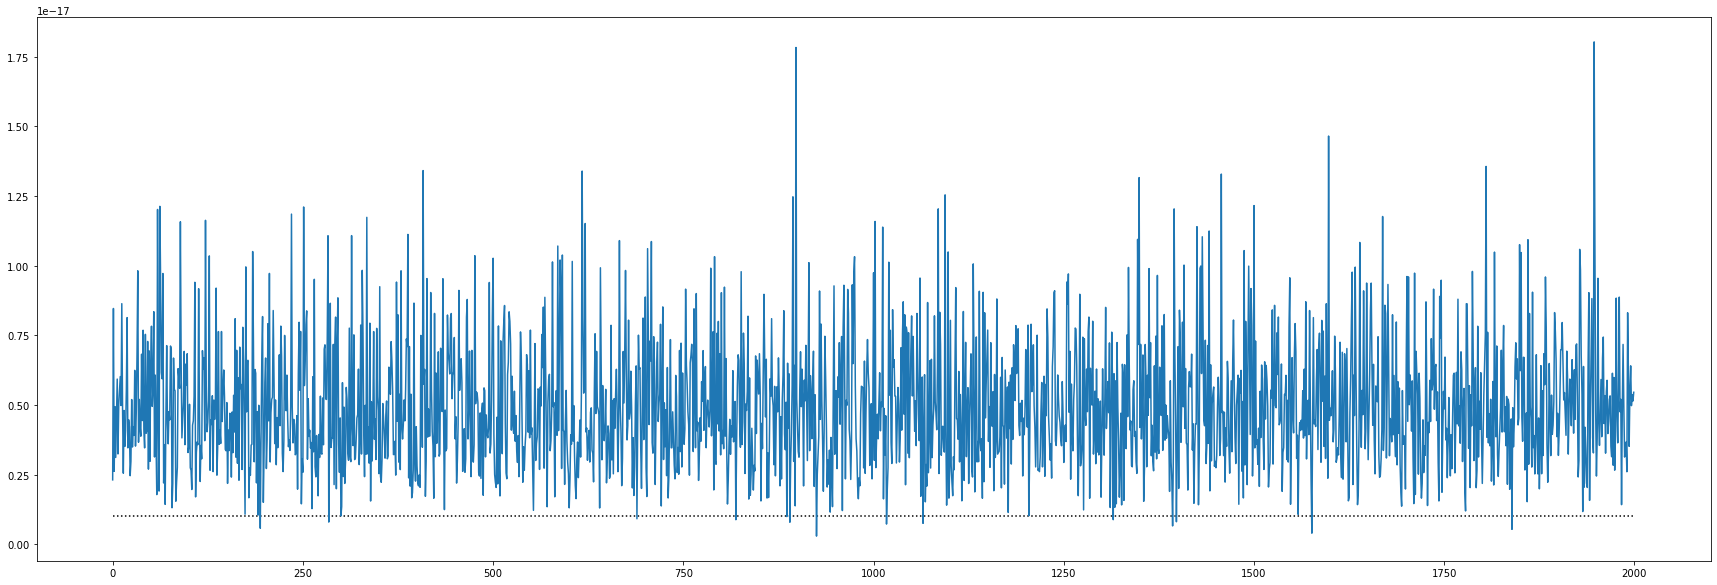

In [10]:
plt.figure(figsize=(30,10))
plt.plot(range(len(UCB_rewards)), UCB_rewards)
plt.hlines([avg_random_reward], 0, len(UCB_rewards), color='k', ls=':')

In [11]:
UCB_rewards = [bandit_env.generate_reward(agent.select_action()) for _ in range(ITERS)]
UCB_rewards = np.array([UCB_rewards])
avg_UCB_reward = UCB_rewards.mean()
std_UCB_reward = UCB_rewards.std()

print(f"\nReturn of UCB policy: {avg_UCB_reward} ± {std_UCB_reward}")

/home/kyriakos/anaconda3/envs/tfagents/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide



Return of UCB policy: 4.943653616319602e-18 ± 2.247266710596049e-18
